# Navigating the perils of a model grid

---

## Overview
The coordinate system that is computationally practical for model simulations is not always intuitive for the slicing and dicing required by analysis. 

1. Intuitive notion of spatial distributions in latitude-longitude coordinates 
1. Reality of model grids


---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import intake
import numpy as np
import xarray as xr

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import pyleoclim as pyleo

## Intuition

The world we live and move in is round, and locations can sensibly be described in terms of latitude and longitude. With this in mind, it doesn't seem unreasonable to expect spatially resolved data to behave similarly. I know that precipitation  follows a distribution of sorts. Let's look at a quick example. 

### Data on a lat-lon grid

In [2]:
# for Google Cloud:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
query_d = dict(source_id='MIROC-ES2L', 
     experiment_id='historical', 
     grid_label='gn', 
     variable_id='pr', 
     member_id = 'r1i1p1f2',
     table_id='Amon'
    )

In [4]:
# sometimes it's necessary to request the data twice
search_res = col.search(**query_d).to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})
miroc_ds = list(search_res.values())[0]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
# convert prate_mean from kg/(m^2*s) to mm/day
prate_unit_conversion = 86400
miroc_ds=miroc_ds.assign(pr_mmday=miroc_ds['pr'] * prate_unit_conversion)

In [6]:
month = 3
year = 1877
m_snapshot_data = miroc_ds.isel(time=(miroc_ds.time.dt.year == year) & (miroc_ds.time.dt.month == month))

The data are arranged in a 64x128 array, with each entry corresponding to a (lon, lat) location. 
To plot a filled contour map, we make a couple of simple adjustments, appending 360 to the longitude coordinate (a vector), and appending the first value in every row of the array to the end. These make sure the data reflect longitude=0 is the same as longitude=360. Then we just pass the latitude and longitude vectors with the values at those points and are rewarded by a pleasing figure. Exceptionally orderly.

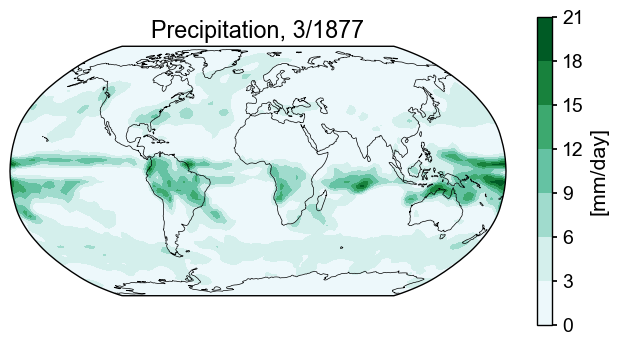

In [7]:
var = 'pr_mmday'
colorbar_units = '[mm/day]'
ppt_cmap = 'BuGn'
title_copy = 'Precipitation, {}/{}'

fig = plt.figure(figsize=(8, 4))

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(m_snapshot_data[var], m_snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,m_snapshot_data['lat'],tas_c.squeeze(), cmap=ppt_cmap,
                   transform=ccrs.PlateCarree())

# add annotations (colorbar, title)
plt.colorbar(cf2, label=colorbar_units, )
ax2.set_title(title_copy.format(month, year));

### Point-wise data

Also very tidy are datasets that reflect measurements taken at specific locations.

In [8]:
month = '13'
po4_woa = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/phosphate/all/1.00/woa18_all_p{}_01.nc'.format(month),
                         decode_times=False)
woa_snapshot_data = po4_woa.sel(depth=100)

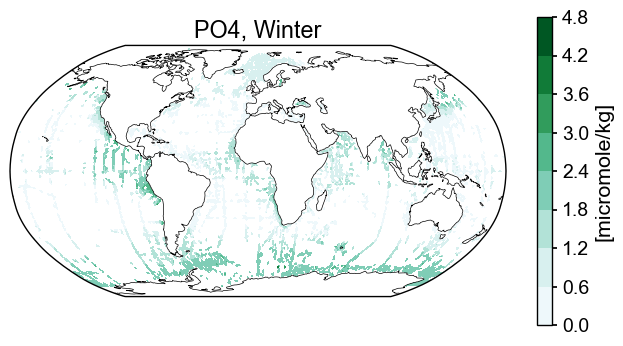

In [9]:
woa_var = 'p_mn'
colorbar_units = '[micromole/kg]'
ppt_cmap = 'BuGn'
title_copy = 'PO4, Winter'

fig = plt.figure(figsize=(8, 4))

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# place data on coordinate system with continuous x axis (longitude axis)
tas_c, lonc = cutil.add_cyclic_point(woa_snapshot_data[woa_var], woa_snapshot_data['lon'])
# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(lonc,woa_snapshot_data['lat'],tas_c.squeeze(), cmap=ppt_cmap,
                   transform=ccrs.PlateCarree())

# add annotations (colorbar, title)
plt.colorbar(cf2, label=colorbar_units)
ax2.set_title(title_copy.format(month, year));

## The reality of model output

While we live in a continuous world, the model version of the world is discritized, and the spatial evolution of a variable through time is calculated using equations that describe fluxes and changes in state between and within gridcells. Suddenly a consistently-spaced latitude-longitude grid is a burden because the optimal way to set up the calculations is nowhere near our favored way of sailing the seas. To make things simpler, modelers choose a grid that will make their calculations simpler (not necessarily based on latitude or longitude), and then report the location the latitude-longitude location of each grid cell as part of their output.  

_Sometimes_, output will be reprocessed such that it is reported with respect to a standardized grid. Those are pleasant days :) 

### PMIP LGM
Let's look at some output from a CMIP6 PMIP LGM experiment.  First we'll load it in, then extract a surface (data that fall on a single depth surface) at a particular timestamp.  

In [10]:
# for Google Cloud:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

query_d = dict(
     experiment_id='lgm', 
     variable_id='po4', 
    )

# sometimes it's necessary to request the data twice
search_res = col.search(**query_d).to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})

miroc_ds_lgm = list(search_res.values())[0]



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [193]:
month = 3
year = 3290
var = 'po4'
lev= 7.800e+01#2.590e+03#3.5#7.800e+01
colorbar_units = r'[$\mu$mole/kg]'
ppt_cmap = 'BuGn'
title_copy = 'Phosphate, {}/{}'

In [194]:
mlgm_snapshot_data = miroc_ds_lgm.isel(time=(miroc_ds_lgm.time.dt.year == year) & (miroc_ds_lgm.time.dt.month == month))
mlgm_snapshot_data = mlgm_snapshot_data.sel(lev=lev)

mlgm_snapshot_data = mlgm_snapshot_data[var].squeeze()
mlgm_snapshot_data = mlgm_snapshot_data.compute()

And let's plot...

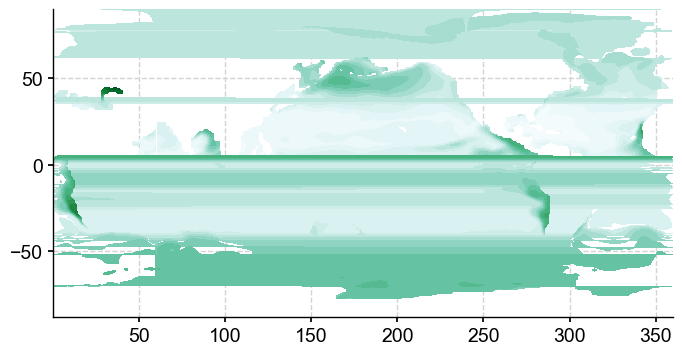

In [15]:
nc = 21
fig = plt.figure(figsize=(8, 4))
ax2 = fig.add_subplot()
ax2.contourf(mlgm_snapshot_data['longitude'],mlgm_snapshot_data['latitude'],mlgm_snapshot_data, nc, cmap='BuGn')#nc,**cf2_kwargs)


A mess... curious. Let's have a look at the underlying grid.

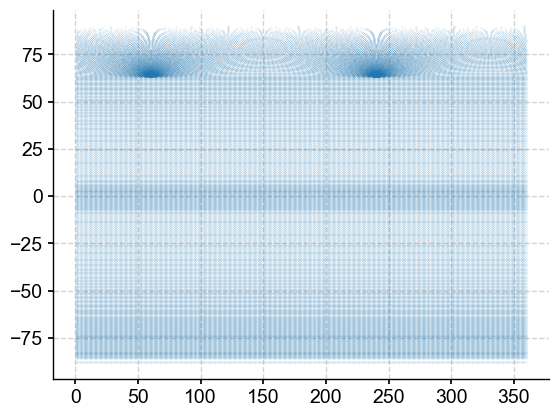

In [16]:
plt.scatter(mlgm_snapshot_data.longitude, mlgm_snapshot_data.latitude, s=.0051);

Very rectangular south of about 60N, and potentially regular north of that. Let's have a quick look a the distribution of the data to see whether there are outliers to be aware of might throw off a colorbar.

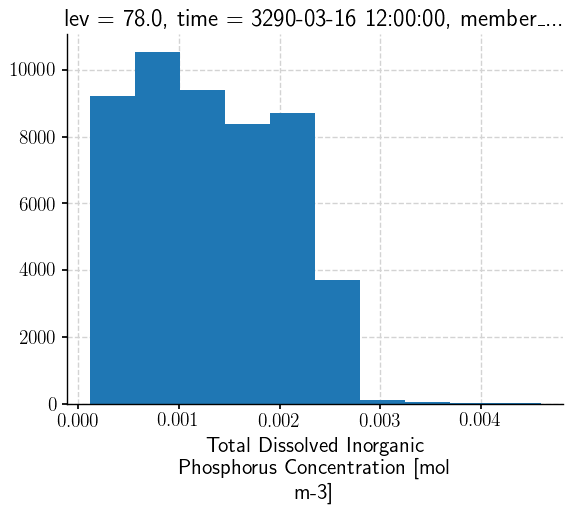

In [196]:
bins =mlgm_snapshot_data.plot.hist()
bin_edges = bins[1]

Might not hurt to curb that a bit.

In [197]:
# establish scale
max_lim = bin_edges[5]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [20]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if type(cmap)==list:
        if n is None:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
        else:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"], N=n)
    else:
        if n is None:
            ax_cmap = plt.get_cmap(cmap)
        else:    
            ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [200]:
n_levels= 60
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=6)#0.0026, .003, 15), decimals=6)
# make scalar mappable
ax2_sm_po4 = make_scalar_mappable([min_lim, max_lim],'BuGn' , n_levels)#[0.0026, .003]
cf2_kwargs_po4 = {'cmap':ax2_sm_po4.cmap,'levels':ax2_levels, 'norm' : ax2_sm_po4.norm}#mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=0.0026, vmax=max_val), 'levels':ax2_levels}#SymLogNorm(.00152, linscale=.003)}#, vmin=None, vmax=None, clip=False)ax2_sm.norm}

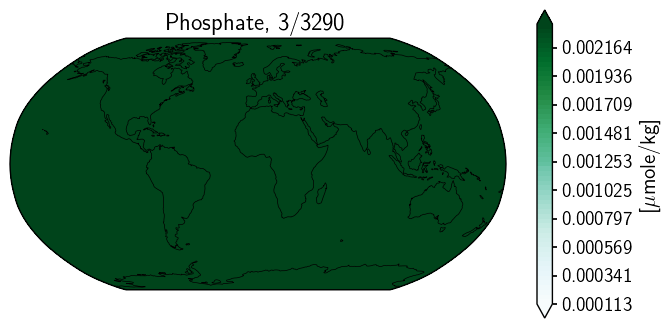

In [199]:
fig = plt.figure(figsize=(8, 4))

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

# plot contourf on ax2 (geosubplot)
cf2 = ax2.contourf(mlgm_snapshot_data['longitude'],mlgm_snapshot_data['latitude'],mlgm_snapshot_data, nc,
                               transform=ccrs.PlateCarree(),extend='both', **cf2_kwargs_po4)

# add annotations (colorbar, title)
plt.colorbar(cf2, label=colorbar_units, format=FormatStrFormatter('%g'))
ax2.set_title(title_copy.format(month, year));


Odd. And honestly, I have not yet fully unravelled the mystery here. However, thninking about the streaky one above, there may be something to be investigated. The longitude data does not appear to be sorted. This may be part of our problem. 

Let's pull the longitude grid, use `argsort` which will yield an array that indicates how the values of each row would need to be reordered so that longitude would me monotonically increasing. 

In [40]:
inds = mlgm_snapshot_data.longitude.argsort()

As an experiment, let's reorder all the data accordingly. Longitude, latitude, and phosphate. Also, let's append the first value of each row to the end of each row to account for the fact taht 0E=360E. (If we were working with an array of longitude values as we did with precipitation, we could use `add_cyclic_point`.)

In [41]:
tmp = mlgm_snapshot_data
tmp_data = tmp.squeeze().data
tmp_lon = tmp.longitude.data
tmp_lat = tmp.latitude.data

numpy_tmp = np.array([tmp_data[row_num][inds[row_num]] for row_num in range(inds.shape[0])])
numpy_tmp_lon = np.array([tmp_lon[row_num][inds[row_num]] for row_num in range(inds.shape[0])])
numpy_tmp_lat = np.array([tmp_lat[row_num][inds[row_num]] for row_num in range(inds.shape[0])])

numpy_tmp= np.concatenate([numpy_tmp, numpy_tmp[:,0].reshape((len(numpy_tmp),1))], axis=1)
numpy_tmp_lat= np.concatenate([numpy_tmp_lat, numpy_tmp_lat[:,0].reshape((len(numpy_tmp_lat),1))], axis=1)
numpy_tmp_lon= np.concatenate([numpy_tmp_lon, np.ones((len(tmp_lon), 1))*360], axis=1)

And we'll try again...

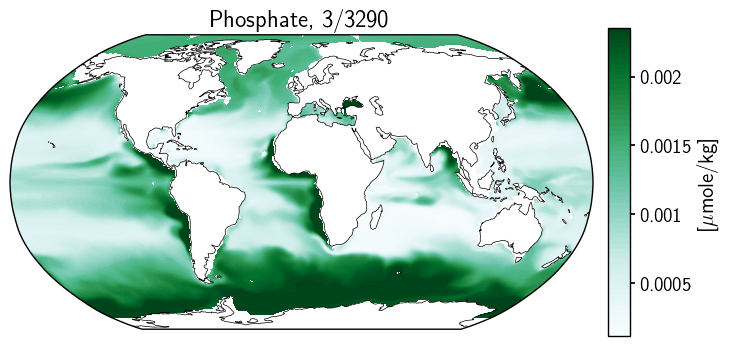

In [201]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

cf2 = ax2.contourf(numpy_tmp_lon,numpy_tmp_lat,numpy_tmp, nc,
                   transform=ccrs.PlateCarree(),extend='both', **cf2_kwargs_po4)#transform=ccrs.PlateCarree()# levels=ax2_levels,

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_po4,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))
                    
ax2.set_title(title_copy.format(month, year));


With further investigation, it turns out that the restructuring we went through above is similar to specifying `transform_first=True`. Nice to have some intuition for what that parameter affects. Have a look below:

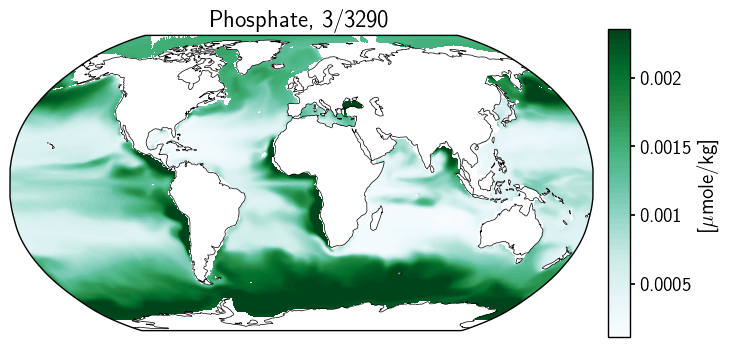

In [202]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

cf2 = ax2.contourf(mlgm_snapshot_data['longitude'],mlgm_snapshot_data['latitude'],mlgm_snapshot_data, nc,
                   transform=ccrs.PlateCarree(),extend='both',transform_first=True, **cf2_kwargs_po4)#transform=ccrs.PlateCarree()# levels=ax2_levels,

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_po4,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))
                    
ax2.set_title(title_copy.format(month, year));


Another option is to use `pcolormesh` which avoids the smoothing that goes into calculating contours and colors based on the value associated with each cell. If the underlying grid is regular, filled contours are an option, otherwise, `pcolormesh` is likely a better choice.

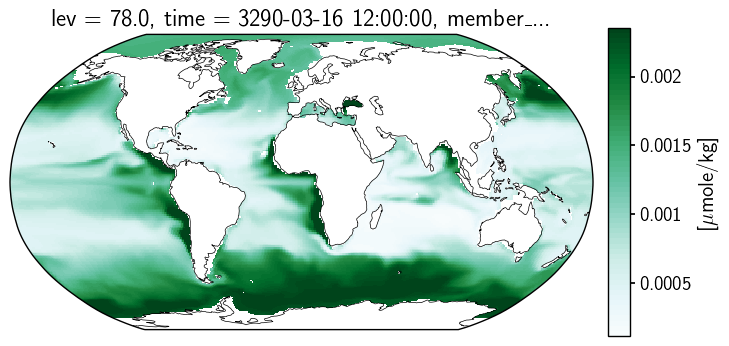

In [203]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

mlgm_snapshot_data.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='longitude', y='latitude', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs_po4['cmap'], 
                                  norm=cf2_kwargs_po4['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)

# ax2 = add_lat_lon_labels(ax2, lon_locs=[-180, -30, 0, 45, 170])

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_po4,cax=ax2_cb, orientation='vertical',label=colorbar_units, 
                   format=FormatStrFormatter('%g')
                  )
cb2.minorticks_off() 

### C-iTRACE

Now, let's look at how this presents for the C-iTRACE output. The data arrray is the set of values at 11,600 locations arranged in a 116x100 array. The `TLAT` and `TLONG` coordinates each describe the latitude or longitude of each location. 

Let's load a slice of output and plot `TLAT` and `TLONG` to get a sense of the grid. 

In [48]:
from pathlib import Path
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [272]:
var = 'd18O'
colorbar_units = r'[\textperthousand]'
time = -21.99
depth = 750
title_var = r'$\delta^{18}$O '
traits = 'depth={} m, time={} kya'

In [57]:
file_name = 'ctrace.decadal.{}.nc'.format(var)
file_path = PF_data_dir/'netcdf3'/file_name
ctrace = xr.open_dataset(file_path, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

# convert prate_mean from kg/(m^2*s) to mm/day
depth_unit_conversion = 1/100
ctrace=ctrace.assign(z_t_m=ctrace['z_t'] * depth_unit_conversion)
ctrace = ctrace.swap_dims({'z_t':'z_t_m'})

In [58]:
ctrace

<xarray.Dataset>
Dimensions:     (nlat: 116, nlon: 100, time: 2200, z_t_m: 60, d2: 2)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -22.0 -21.99 -21.98 -21.97 ... -0.03 -0.02 -0.01
    z_t         (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m       (z_t_m) float32 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    d18O        (time, z_t_m, nlat, nlon) float32 ...
    time_bound  (time, d2) float64 ...
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:24:12 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:24:12 2021: Appended file /glad...

In [274]:
c_snapshot_data = ctrace.sel(time = time, method='nearest')
c_snapshot_data = c_snapshot_data.sel(z_t_m=depth, method='nearest')

In [275]:
c_snapshot_data = c_snapshot_data[var].squeeze()
c_snapshot_data = c_snapshot_data.compute()

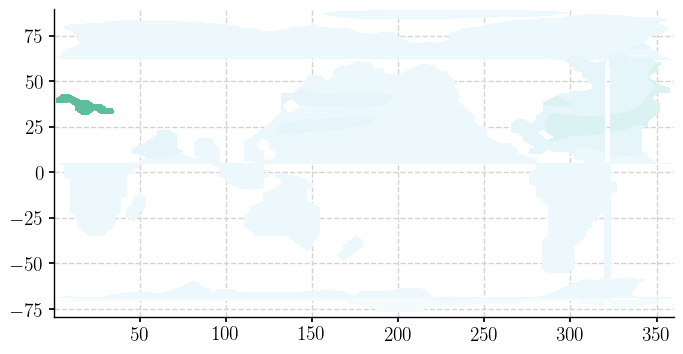

In [63]:
fig = plt.figure(figsize=(8, 4))
ax2 = fig.add_subplot()
ax2.contourf(c_snapshot_data['TLONG'],c_snapshot_data['TLAT'],c_snapshot_data, nc, cmap='BuGn')#nc,**cf2_kwargs)

Text(0, 0.5, 'Latitude ($^{\\circ}$N)')

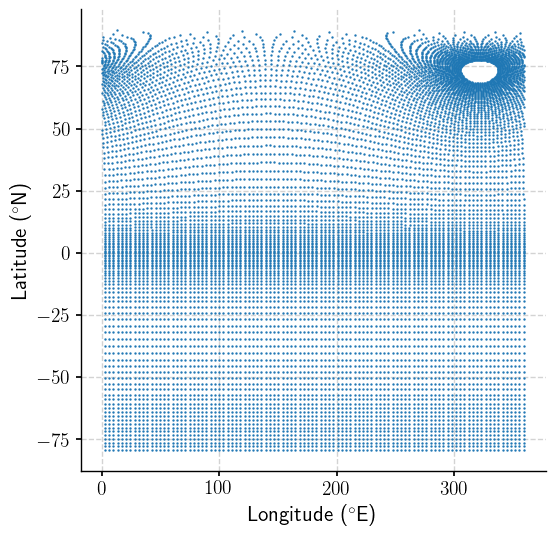

In [278]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(c_snapshot_data.TLONG, c_snapshot_data.TLAT, s=.51);
ax.set_xlabel(r'Longitude ($^{\circ}$E)')
ax.set_ylabel(r'Latitude ($^{\circ}$N)')


So while the data sit on a 116 x 100 grid, neither the rows, nor the columns follow lines of constant latitude or longitude north of about 25N. 

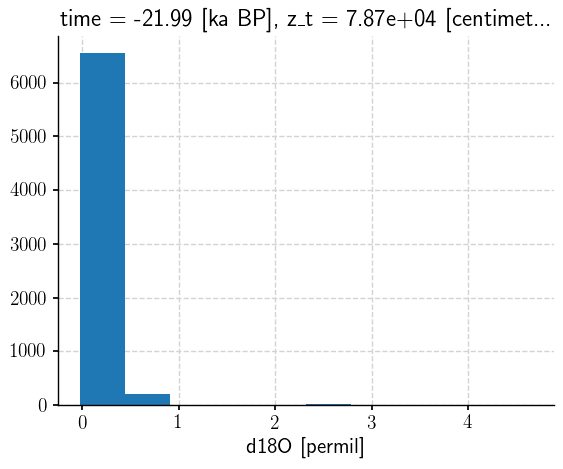

In [279]:
bins =c_snapshot_data.plot.hist()
bin_edges = bins[1]

In [280]:
# establish scale
max_lim = bin_edges[3]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [281]:
n_levels= 60
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)
# make scalar mappable
ax2_sm_d18O = make_scalar_mappable([min_lim, max_lim],'BuGn' , n_levels)
cf2_kwargs_d18O = {'cmap':ax2_sm_d18O.cmap,'levels':ax2_levels, 'norm' : ax2_sm_d18O.norm}

Given the model grid issue, we can go about this in one of three ways:
#### 1. Scatterplot

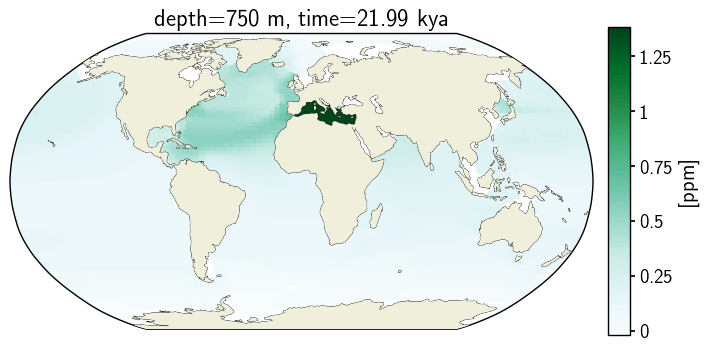

In [175]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

ax2.scatter(c_snapshot_data.TLONG,c_snapshot_data.TLAT,c=c_snapshot_data, transform=ccrs.PlateCarree(), 
            cmap=cf2_kwargs_d18O['cmap'], norm=cf2_kwargs_d18O['norm'])
ax2.add_feature(cfeature.LAND, zorder=14)

cb2 = plt.colorbar(ax2_sm_d18O,cax=ax2_cb, orientation='vertical',label=' '.join([title_var,colorbar_units]),
                   format=FormatStrFormatter('%g'))
ax2.set_title(traits.format(depth, -1*time));


#### 2. Pcolormesh

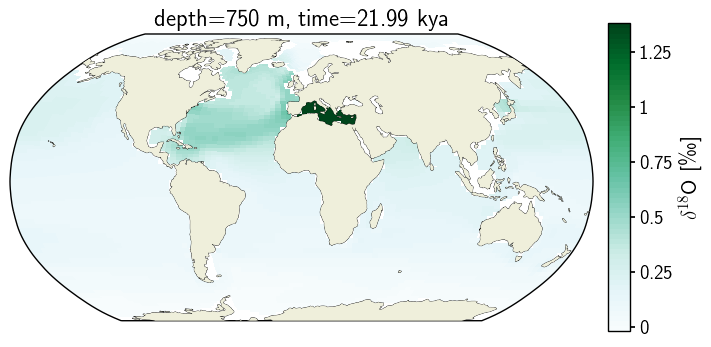

In [191]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs_d18O['cmap'], 
                                  norm=cf2_kwargs_d18O['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_d18O,cax=ax2_cb, orientation='vertical',label=' '.join([title_var,colorbar_units]),
                   format=FormatStrFormatter('%g'))
ax2.set_title(traits.format(depth, -1*time));


#### 3. Filled Contour
Or as a filled contour, but ONLY if we specify to transform the data before doing the contour calculations.

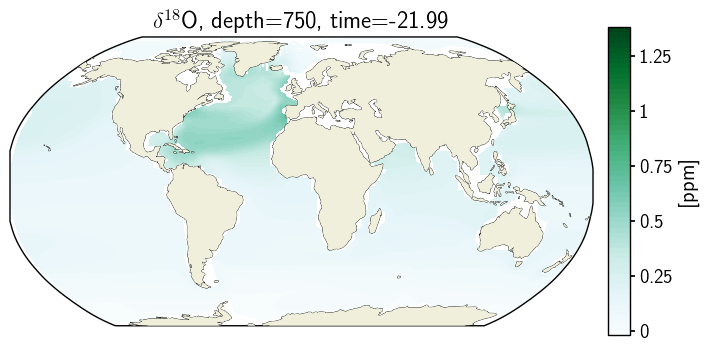

In [75]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

cf2 = ax2.contourf(c_snapshot_data.TLONG,c_snapshot_data.TLAT,c_snapshot_data,  ax2_levels,#cmap='BuGn',
                   transform=ccrs.PlateCarree(),cmap=cf2_kwargs_d18O['cmap'], transform_first=True,
                                  norm=cf2_kwargs_d18O['norm'], extent='both'#, **cf2_kwargs)#transform=ccrs.PlateCarree()# levels=ax2_levels,
                  )

ax2.add_feature(cfeature.LAND, zorder=14)
# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm_d18O,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))                    

ax2.set_title(title_var+traits.format(depth, time));


### Selecting along lat/lon

From the perspective of xarray there are dimensions, which describe degrees of freedom, and coordinates which create context around those dimensions. For example, in the examples below, there are spatial dimensions that describe the number of points in each aspect of the underlying grid, however there are separate coordinates that associate a point on the grid with a lat-lon pair. 

When a dimension is also a coordinate, we can use `.sel()` to select using either the dimension system or the coordinate system. Furthermore, we can specify `.sel(method='nearest')` to return the nearest match. 

#### Selecting using coordinate-dimensions
time and depth are consistent throughout the dataset

In [257]:
# select data closest to specified time and depth values
snapshot_ds = ctrace.sel(time = time, z_t_m=depth, method='nearest')

#### Selecting using dimensions
The histogram of data on the lon dimension with index 55 shows that though there is a dominent longitude band, there are multiple longitudes involved.

In [258]:
np.median(snapshot_ds.sel(nlon=55).TLONG.data)

161.30101007080071

<Axes: ylabel='Count'>

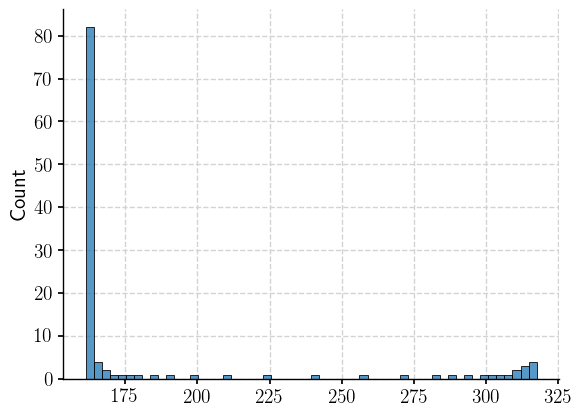

In [259]:
# select data on a single dimension value
sns.histplot(x=snapshot_ds.sel(nlon=55).TLONG.data)

#### Selecting using `where`
If we were resolute about filtering by longitude, we could filter the TLONG arrays for values in a certain window. 

In [260]:
def between_ds(ds, var, lims):
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

In [263]:
section_ds = between_ds(snapshot_ds, 'TLONG',[160, 163])

In [264]:
section_ds['d18O'].TLONG.mean(dim='nlat')

<xarray.DataArray 'TLONG' (nlon: 5)>
array([147.29784258, 151.13834525, 154.95023564, 158.73244459,
       162.48678877])
Coordinates:
    time     float64 -21.99
    z_t      float32 7.87e+04
    z_t_m    float32 787.0
Dimensions without coordinates: nlon

<Axes: ylabel='Count'>

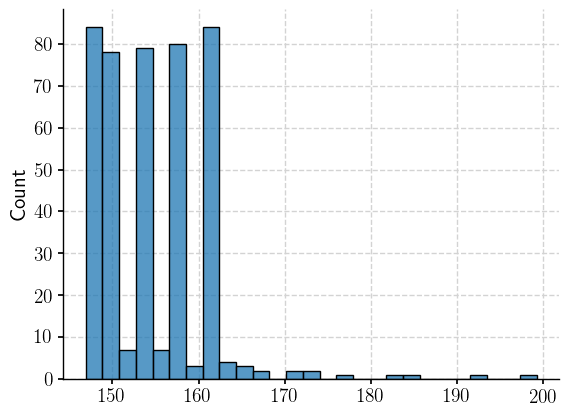

In [265]:
# nan_filter = np.isnan(section_ds['d18O'].data)
sns.histplot(x=section_ds['d18O'].TLONG.data.ravel())

That's thought provoking...we filtered for (160, 163)... Let's fix up a scatterplot of the the latitude-longitude pairs still part of this filtered dataset.

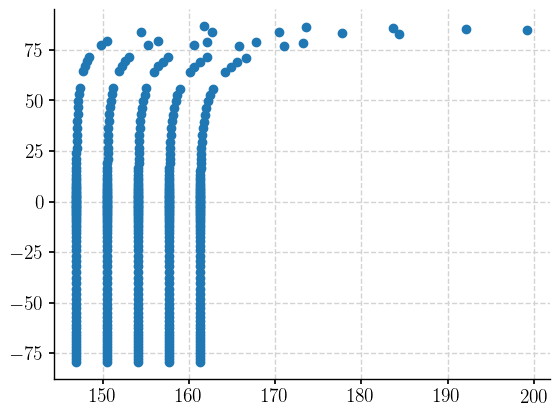

In [266]:
plt.scatter(section_ds['d18O'].TLONG.data, section_ds['d18O'].TLAT.data)

It becomes clear!  The filtered dataset retains all nlon values that have an TLONG value in our range. If we pull the data out and use numpy to make a masking array for the nans, and then apply that mask to the TLONG array, we will hopefully find that the values still in our filtered dataset correspond to longitude values in our desired range. Let's see...

<Axes: ylabel='Count'>

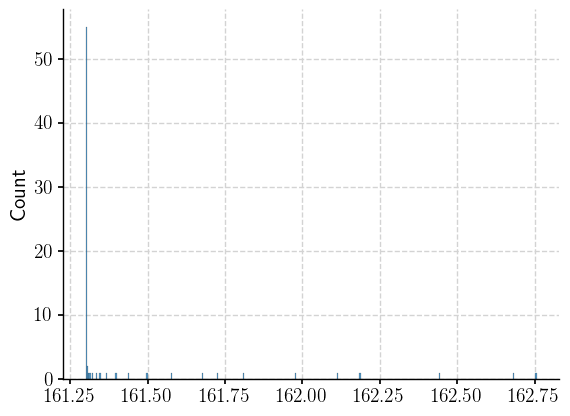

In [267]:
nan_filter = np.isnan(section_ds['d18O'].data)
sns.histplot(x=section_ds.TLONG.data[~nan_filter])

Success! This exercise has also clarified a bit more about how Xarray treats dimensions and coordinates. Below are a pair of maps illustrating that the range of `TLONG` values yielded by a `where` filter is more restricted than that based on a single `nlon` dimension value. The color is simply to highlight which locations are contained in each set. 

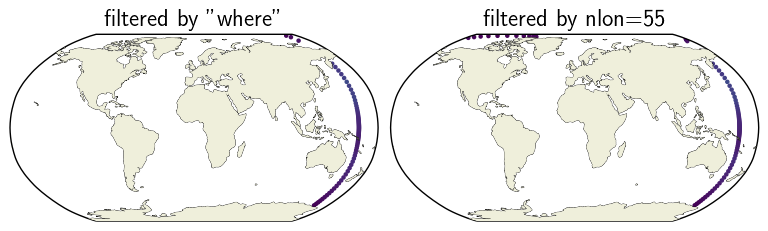

In [292]:
fig = plt.figure(figsize=(10, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 3, wspace=0.05, width_ratios=[8,8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax_sel = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax_sel.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

scatter = ax_sel.scatter(section_ds.TLONG,section_ds.TLAT,c=section_ds['d18O'].squeeze(), transform=ccrs.PlateCarree(), 
             s=5,cmap='viridis', norm=cf2_kwargs['norm'])
ax_sel.add_feature(cfeature.LAND, zorder=14)
ax_sel.set_global()
ax_sel.set_title('filtered by "where"')

ax_nlon = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson(central_longitude=0))
ax_nlon.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

scatter = ax_nlon.scatter(snapshot_ds.sel(nlon=55).TLONG,snapshot_ds.sel(nlon=55).TLAT,c=snapshot_ds.sel(nlon=55)['d18O'].squeeze(), transform=ccrs.PlateCarree(), 
             cmap='viridis', norm=cf2_kwargs_d18O['norm'], s=5)
ax_nlon.add_feature(cfeature.LAND, zorder=14)
ax_nlon.set_global()
ax_nlon.set_title('filtered by nlon=55');


---

## Summary
Model grids are worthy of many hours of rabbit hole time (if you're keen to stare at a wall and think about some fascinating topology questions), but a few exploratory plots can go a long way to understanding what is in the mix. 


## Resources and references


| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|Gu, Sifan, Liu, Zhengyu, Jahn, Alexandra, Zanowski, Hannah. (2021). C-iTRACE. Version 1.0. UCAR/NCAR - DASH Repository. https://doi.org/10.5065/hanq-bn92. 
|Ohgaito, R. & Yamamoto, Akitomo & Hajima, Tomohiro & O'ishi, Ryouta & Abe, Manabu & Tatebe, Hiroaki & Abe-Ouchi, Ayako & Kawamiya, M.. (2020). PMIP4 experiments using MIROC-ES2L Earth System Model. 10.5194/gmd-2020-64. 
|Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|
|Garcia, H. E., K. Weathers, C. R. Paver, I. Smolyar, T. P. Boyer, R. A. Locarnini, M. M. Zweng, A. V. Mishonov, O. K. Baranova, D. Seidov, and J. R. Reagan, 2018. World Ocean Atlas 2018, Volume 4: Dissolved Inorganic Nutrients (phosphate, nitrate and nitrate+nitrite, silicate). A. Mishonov Technical Ed.; NOAA Atlas NESDIS 84, 35pp. 